## Data sources

In order to validate the claims from [this](https://www.bloomberg.com/news/articles/2020-05-11/why-chicken-is-plentiful-during-the-pandemic-and-beef-is-not?srnd=premium&utm_medium=social&utm_source=twitter&utm_campaign=socialflow-organic&utm_content=markets&cmpid%3D=socialflow-twitter-markets&sref=XQtHDW1P) article, I pulled price data from FRED (which sources data from the BLS) and adjusted it using the CPI. Data sources are here:

- [Data finder](https://beta.bls.gov/dataQuery/find?st=0&r=20&s=popularity%3AD&more=0)
- [CPI (for inflation)](https://fred.stlouisfed.org/series/CPIAUCSL)
- [Poultry](https://fred.stlouisfed.org/series/APU0000706111)
- [Pork](https://fred.stlouisfed.org/series/APU0000FD3101)
- [Beef](https://fred.stlouisfed.org/series/APU0000703112)

In [11]:
(1.64 - 4.30) / 4.30

-0.6186046511627907

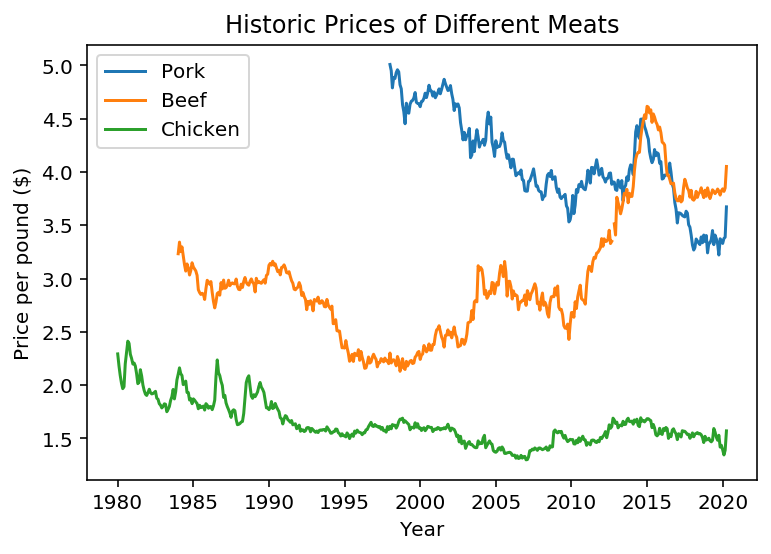

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from IPython.core.display import HTML

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# https://github.com/jupyter/notebook/issues/3670
%matplotlib inline

%config InlineBackend.figure_format = 'retina'
%run ./helpers.ipynb

cpi = pd.read_csv('data/CPIAUCSL.csv')

# Get most recent cpi
MOST_RECENT = cpi.loc[cpi['DATE'] == cpi['DATE'].max(), 'CPIAUCSL'].values[0]

df = (
    beef()
    .pipe(pd.merge, chicken(), how='outer')
    .pipe(pd.merge, pork(), how='outer')
    .pipe(pd.merge, cpi, how='outer', on='DATE')
    .rename(columns={'APU0000703112':'beef',
                     'APU0000706111':'chicken',
                     'APU0000FD3101':'pork',
                     'CPIAUCSL':'cpi',
                     'DATE':'date'})
)

df['date'] = pd.to_datetime(df['date'])
df['beef'] = pd.to_numeric(df['beef'],errors='coerce')
df.sort_values(by=['date'], inplace=True)

df['new_pork'] = apply_adjust(df, 'pork', MOST_RECENT)
df['new_chicken'] = apply_adjust(df, 'chicken', MOST_RECENT)
df['new_beef'] = apply_adjust(df, 'beef', MOST_RECENT)

plt.plot(df['date'], df['new_pork'], label='Pork');
plt.plot(df['date'], df['new_beef'], label='Beef');
plt.plot(df['date'], df['new_chicken'], label='Chicken');

plt.legend(loc="upper left");
plt.xlabel("Year");
plt.ylabel("Price per pound ($)")
plt.title("Historic Prices of Different Meats");

In [48]:
import seaborn as sns
FILES = ['data/file-2.csv', 'data/file-3.csv', 'data/file-4.csv']
stacked = pd.concat(
    [pd.read_csv(x) for x in FILES]
)

stacked['Date'] = pd.to_datetime(stacked['Label'])
stacked.sort_values(by=['Date'], inplace=True)
stacked.head()

,Series ID,Year,Period,Label,Value,Date
0,CUUR0000SEFF,1935,M01,1935 Jan,32.4,1935-01-01
0,CUUR0000SEFD,1935,M01,1935 Jan,13.0,1935-01-01
0,CUUR0000SEFC,1935,M01,1935 Jan,10.2,1935-01-01
1,CUUR0000SEFF,1935,M02,1935 Feb,34.5,1935-02-01
1,CUUR0000SEFD,1935,M02,1935 Feb,13.3,1935-02-01


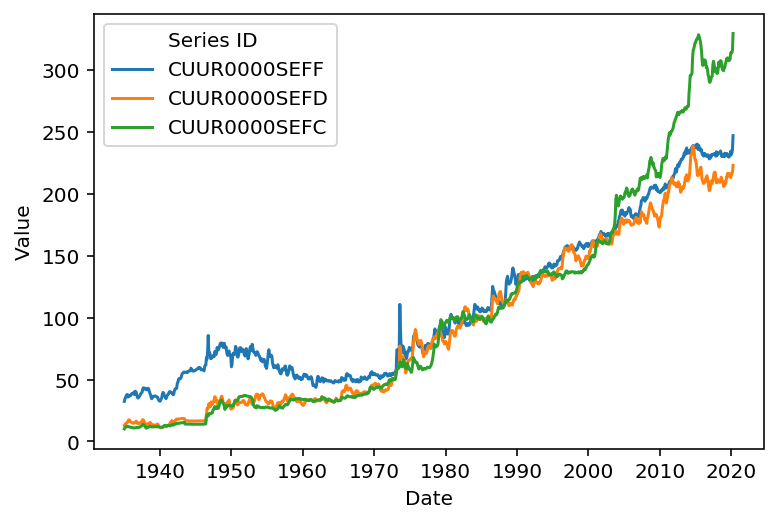

In [51]:
sns.lineplot(x='Date', y='Value', hue='Series ID', data=stacked);

## Claims

> "poultry costs U.S. consumers 62% less in inflation-adjusted terms than it did in 1935"

> "Pork, now also raised mostly at factory scale indoors, is 12% cheaper"

> "Beef, which isn’t, costs 63% more."

Here's what I found:

- From 1980 - 2020, chicken prices have declined 31.5%.
- From 1998 - 2020, the price of pork has declined 26%.
- From 1984 - 2020, the price of beef has increased 25.3%.

But it wouldn't be fair to compare these numbers to his numbers, because my data has a different number of years. I'll very simply extrapolate backwards using the growth rate I have from my data.

In [22]:
TYPES = ['chicken', 'pork', 'beef']

diff = pd.DataFrame({
    'type':TYPES,
    
    # My pct differences
    'm_change':[get_diff(df, x, True) for x in TYPES],
    # Fox's changes
    'h_change' :[-.62, -.12, .63],
    
    # Add my years
    'm_year':[2020 - 1980, 2020 - 1998, 2020 - 1984],
    # Fox's year range
    'h_year': np.repeat(2020 - 1935, 3)
})

diff = (diff
    # Extrapolation here
    .assign(m_adjusted = lambda x: (x['m_change'] / x['m_year'])*x['h_year'])
    .assign(error = lambda x: x['m_adjusted'] - x['h_change'])
    .rename(columns={
        'type':'Type',
        'm_change':'My pct change',
        'm_year':'My Years',
        'h_change':'His pct change',
        'h_year':'His years',
        'm_adjusted':'My extrapolated change',
    })
)
HTML(diff.drop(labels=['error'], axis=1).round(2).to_html().replace('border="1"','border="0"'))

,Type,My pct change,His pct change,My Years,His years,My extrapolated change
0,chicken,-0.31,-0.62,40,85,-0.67
1,pork,-0.27,-0.12,22,85,-1.03
2,beef,0.25,0.63,36,85,0.60


Now I can look at how far off I was (mine - his).

In [23]:
HTML(
    diff[['Type', 'error']]
    .round(2).to_html()
    .replace('border="1"','border="0"')
)

,Type,error
0,chicken,-0.05
1,pork,-0.91
2,beef,-0.03
